# Predict Winner Of Regular Season NFL Matchup Using Historical Data

**Objective**: Predict the winner of NFL team matchups using data from 1999 to now 

In [1]:
# NFL api
import nfl_data_py as nfl

# Data manipulation
import pandas as pd
import numpy as np

# Statistical test
import scipy.stats as stats

# Data visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Machine learning
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the year range
yr_range = list(range(1999, 2025))

In [3]:
# Import matchups
nfl_matchups_df = nfl.import_schedules(yr_range)
nfl_matchups_df.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17,ATL,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17,CHI,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43,CLE,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,OAK,24,GB,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14,IND,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome


In [4]:
# Fix team names that changed over time
tm_abbr_map = {"SD": "LAC", "STL": "LA", "OAK": "LV"}
nfl_matchups_df["home_team"] = nfl_matchups_df["home_team"].replace(tm_abbr_map)
nfl_matchups_df["away_team"] = nfl_matchups_df["away_team"].replace(tm_abbr_map)

In [5]:
# Info on the data
nfl_matchups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6991 entries, 0 to 6990
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   game_id           6991 non-null   object 
 1   season            6991 non-null   int64  
 2   game_type         6991 non-null   object 
 3   week              6991 non-null   int64  
 4   gameday           6991 non-null   object 
 5   weekday           6991 non-null   object 
 6   gametime          6732 non-null   object 
 7   away_team         6991 non-null   object 
 8   away_score        6991 non-null   int64  
 9   home_team         6991 non-null   object 
 10  home_score        6991 non-null   int64  
 11  location          6991 non-null   object 
 12  result            6991 non-null   int64  
 13  total             6991 non-null   int64  
 14  overtime          6991 non-null   int64  
 15  old_game_id       6991 non-null   int64  
 16  gsis              6991 non-null   int64  


In [6]:
# Subset to only specific columns
cols_to_use = [
    "season", "game_type", "week", "gameday", "weekday", "gametime", "home_team", "away_team", "home_rest", "away_rest",
    "home_moneyline", "away_moneyline", "home_score", "away_score"
    ]
nfl_matchups_sub_df = nfl_matchups_df[cols_to_use]
nfl_matchups_sub_df.head()

,season,game_type,week,gameday,weekday,gametime,home_team,away_team,home_rest,away_rest,home_moneyline,away_moneyline,home_score,away_score
0,1999,REG,1,1999-09-12,Sunday,NaN,ATL,MIN,7,7,NaN,NaN,14,17
1,1999,REG,1,1999-09-12,Sunday,NaN,CHI,KC,7,7,NaN,NaN,20,17
2,1999,REG,1,1999-09-12,Sunday,NaN,CLE,PIT,7,7,NaN,NaN,0,43
3,1999,REG,1,1999-09-12,Sunday,NaN,GB,LV,7,7,NaN,NaN,28,24
4,1999,REG,1,1999-09-12,Sunday,NaN,IND,BUF,7,7,NaN,NaN,31,14


In [7]:
# Add a column that has the moneyline of the team that won and if the home team won or lost
nfl_matchups_sub_df["tm_won_moneyline"] = np.where(nfl_matchups_sub_df["home_score"] > nfl_matchups_sub_df["away_score"], nfl_matchups_sub_df["home_moneyline"], nfl_matchups_sub_df["away_moneyline"])
nfl_matchups_sub_df["home_won"] = np.where(nfl_matchups_sub_df["home_score"] > nfl_matchups_sub_df["away_score"], 1, 0)
nfl_matchups_sub_df["away_won"] = np.where(nfl_matchups_sub_df["home_score"] > nfl_matchups_sub_df["away_score"], 0, 1)


# Drop the columns bc they are not needed
nfl_matchups_sub_df.drop(columns=["home_moneyline", "away_moneyline", "home_score", "away_score"], inplace=True)

nfl_matchups_sub_df.head(3)

,season,game_type,week,gameday,weekday,gametime,home_team,away_team,home_rest,away_rest,tm_won_moneyline,home_won,away_won
0,1999,REG,1,1999-09-12,Sunday,NaN,ATL,MIN,7,7,NaN,0,1
1,1999,REG,1,1999-09-12,Sunday,NaN,CHI,KC,7,7,NaN,1,0
2,1999,REG,1,1999-09-12,Sunday,NaN,CLE,PIT,7,7,NaN,0,1


In [8]:
# Create a dataframe to store if a team won or lost for a given week
home_team_df = nfl_matchups_sub_df[["season", "week", "home_team", "home_won"]].rename(columns={"home_team": "tm", "home_won": "won"})
away_team_df = nfl_matchups_sub_df[["season", "week", "away_team", "away_won"]].rename(columns={"away_team": "tm", "away_won": "won"})

nfl_matchups_sub_df.drop(columns="away_won", inplace=True)

tm_win_df = pd.concat([home_team_df, away_team_df]).reset_index(drop=True)
tm_win_df.head()

,season,week,tm,won
0,1999,1,ATL,0
1,1999,1,CHI,1
2,1999,1,CLE,0
3,1999,1,GB,1
4,1999,1,IND,1


In [9]:
# Test to see the winning percentage of each team by season
tm_group_df = tm_win_df.groupby(["tm", "season"])

# Store the winning percentage
tm_win_percts = tm_group_df["won"].value_counts(normalize=True)

In [10]:
# Filter the data to after the 2010 season and all regular season games
nfl_matchups_sub_df = nfl_matchups_sub_df[(nfl_matchups_sub_df["season"] > 2010) & (nfl_matchups_sub_df["game_type"] == "REG")].reset_index(drop=True)
nfl_matchups_sub_df.head()

,season,game_type,week,gameday,weekday,gametime,home_team,away_team,home_rest,away_rest,tm_won_moneyline,home_won
0,2011,REG,1,2011-09-08,Thursday,20:30,GB,NO,7,7,-250.0,1
1,2011,REG,1,2011-09-11,Sunday,13:00,BAL,PIT,7,7,-125.0,1
2,2011,REG,1,2011-09-11,Sunday,13:00,CHI,ATL,7,7,105.0,1
3,2011,REG,1,2011-09-11,Sunday,13:00,CLE,CIN,7,7,273.0,0
4,2011,REG,1,2011-09-11,Sunday,13:00,HOU,IND,7,7,-430.0,1


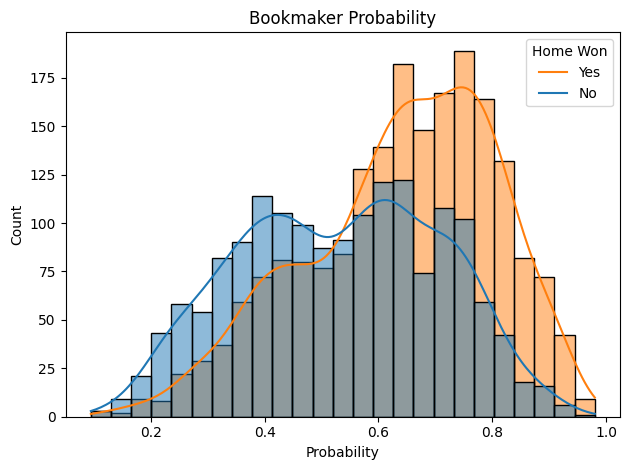

In [11]:
# Plot the histplot of the moneyline as probabilities and if a team won or lost
def convert_moneyline_to_probabilities(moneyline):
    if moneyline < 0:
        return abs(moneyline)/(abs(moneyline)+100)
    return 100/(abs(moneyline)+100)
    

nfl_matchups_sub_df["moneyline_prob"] = nfl_matchups_sub_df["tm_won_moneyline"].apply(convert_moneyline_to_probabilities)

# Histogram
sns.histplot(data=nfl_matchups_sub_df, x="moneyline_prob", hue="home_won", kde=True)
plt.title("Bookmaker Probability")
plt.xlabel("Probability")
plt.legend(title="Home Won", labels=["Yes", "No"])
plt.tight_layout()
plt.show()

In [12]:
# Empty values
nfl_matchups_sub_df.isna().sum()

season              0
game_type           0
week                0
gameday             0
weekday             0
gametime            0
home_team           0
away_team           0
home_rest           0
away_rest           0
tm_won_moneyline    1
home_won            0
moneyline_prob      1
dtype: int64

In [13]:
# Fix date and time columns
nfl_matchups_sub_df["gameday"] = pd.to_datetime(nfl_matchups_sub_df["gameday"])
nfl_matchups_sub_df["gametime"] = pd.to_timedelta(nfl_matchups_sub_df["gametime"] + ":00")

In [14]:
# Remove the date and time columns
nfl_matchups_sub_df.drop(columns=["game_type", "gameday", "gametime"], inplace=True)

In [15]:
# Difference in rest days from home team and away team
nfl_matchups_sub_df.insert(loc=7, column="diff_rest", value=nfl_matchups_sub_df["home_rest"] - nfl_matchups_sub_df["away_rest"])

In [16]:
def prev_season_win_perct(season, team_abbr):
    try:
        perct = tm_win_percts.loc[team_abbr, season-1][1]
    except KeyError:
        perct = 0
    finally:
        return perct

In [17]:
nfl_matchups_sub_df.insert(loc=9, column="win_perct_h", value=nfl_matchups_sub_df.apply(lambda col: prev_season_win_perct(col["season"], col["home_team"]), axis=1))
nfl_matchups_sub_df.insert(loc=9, column="win_perct_a", value=nfl_matchups_sub_df.apply(lambda col: prev_season_win_perct(col["season"], col["away_team"]), axis=1))

In [18]:
# Does the difference of rest days have anything to do with who wins
corr, p_value = stats.pointbiserialr(x=nfl_matchups_sub_df["home_won"], y=nfl_matchups_sub_df["diff_rest"])

if p_value < 0.05:
    print("Correlation observed:", corr, " pvalue: ", p_value)
else:
    print("Correlation not observed:", corr, " pvalue:", p_value)

Correlation not observed: 0.01791032559998776  pvalue: 0.2795514077454158


In [19]:
nfl_matchups_sub_df.head()

,season,week,weekday,home_team,away_team,home_rest,away_rest,diff_rest,tm_won_moneyline,win_perct_a,win_perct_h,home_won,moneyline_prob
0,2011,1,Thursday,GB,NO,7,7,0,-250.0,0.647059,0.700000,1,0.714286
1,2011,1,Sunday,BAL,PIT,7,7,0,-125.0,0.736842,0.722222,1,0.555556
2,2011,1,Sunday,CHI,ATL,7,7,0,105.0,0.764706,0.666667,1,0.487805
3,2011,1,Sunday,CLE,CIN,7,7,0,273.0,0.250000,0.312500,0,0.268097
4,2011,1,Sunday,HOU,IND,7,7,0,-430.0,0.588235,0.375000,1,0.811321


## Encoding Categorical Variables

In [20]:
# Weekday should be grouped as binary variables, so on Sunday or not on Sunday
nfl_matchups_sub_df["weekday"] = np.where(nfl_matchups_sub_df["weekday"] == "Sunday", "Sunday", "Not Sunday")
nfl_matchups_sub_df["weekday"].value_counts()

weekday
Sunday        3063
Not Sunday     584
Name: count, dtype: int64

In [21]:
# Encode the weeekday variable
nfl_matchups_sub_df["weekday"] = pd.get_dummies(nfl_matchups_sub_df["weekday"], dtype=int, drop_first=True)
nfl_matchups_sub_df.head()

,season,week,weekday,home_team,away_team,home_rest,away_rest,diff_rest,tm_won_moneyline,win_perct_a,win_perct_h,home_won,moneyline_prob
0,2011,1,0,GB,NO,7,7,0,-250.0,0.647059,0.700000,1,0.714286
1,2011,1,1,BAL,PIT,7,7,0,-125.0,0.736842,0.722222,1,0.555556
2,2011,1,1,CHI,ATL,7,7,0,105.0,0.764706,0.666667,1,0.487805
3,2011,1,1,CLE,CIN,7,7,0,273.0,0.250000,0.312500,0,0.268097
4,2011,1,1,HOU,IND,7,7,0,-430.0,0.588235,0.375000,1,0.811321


In [22]:
# Save this dataframe for predictions
nfl_predictions_df = nfl_matchups_sub_df.copy()

In [23]:
# Encode the teams
def encode_teams(df, column_name):
    temp_df = pd.get_dummies(df[column_name], dtype=int)
    new_columns =  temp_df.columns.str.lower() + "_" + column_name.split("_")[0][0]
    temp_df.columns = new_columns
    return temp_df

home_tm_enc = encode_teams(nfl_matchups_sub_df, "home_team")
away_tm_enc = encode_teams(nfl_matchups_sub_df, "away_team")

In [24]:
# Drop the home and away teams and concat it to the original dataframe
nfl_matchups_sub_df.drop(columns=["home_team", "away_team", "moneyline_prob"], inplace=True)

# Concat the dataframe
nfl_matchups_clean_df = pd.concat([home_tm_enc, away_tm_enc, nfl_matchups_sub_df], axis=1)
nfl_matchups_clean_df.head()

,ari_h,atl_h,bal_h,buf_h,car_h,chi_h,cin_h,cle_h,dal_h,den_h,...,season,week,weekday,home_rest,away_rest,diff_rest,tm_won_moneyline,win_perct_a,win_perct_h,home_won
0,0,0,0,0,0,0,0,0,0,0,...,2011,1,0,7,7,0,-250.0,0.647059,0.700000,1
1,0,0,1,0,0,0,0,0,0,0,...,2011,1,1,7,7,0,-125.0,0.736842,0.722222,1
2,0,0,0,0,0,1,0,0,0,0,...,2011,1,1,7,7,0,105.0,0.764706,0.666667,1
3,0,0,0,0,0,0,0,1,0,0,...,2011,1,1,7,7,0,273.0,0.250000,0.312500,0
4,0,0,0,0,0,0,0,0,0,0,...,2011,1,1,7,7,0,-430.0,0.588235,0.375000,1


## Machine Learning

In [25]:
# 2022 and up will be the testing data
year_fil = 2022
training_set = nfl_matchups_clean_df[year_fil >= nfl_matchups_clean_df["season"]]
testing_set = nfl_matchups_clean_df[year_fil < nfl_matchups_clean_df["season"]]

print(f"Training size: {training_set.shape[0]}")
print(f"Testing size: {testing_set.shape[0]}")

Training size: 3103
Testing size: 544


In [26]:
# Training data
x_train = training_set.drop(columns=["season", "tm_won_moneyline", "home_won"])
y_train = training_set["home_won"]

# Testing data
x_test = testing_set.drop(columns=["season", "tm_won_moneyline", "home_won"])
y_test = testing_set["home_won"]

In [27]:
# Models
lr = LogisticRegression()
xgb = XGBClassifier()

In [28]:
# Fit the models
lr.fit(x_train, y_train)
xgb.fit(x_train, y_train)

# Predict on unseen data
lr_preds = lr.predict(x_test)
xgb_preds = xgb.predict(x_test)
lr_accuracy_score = accuracy_score(y_test, lr_preds)
xgb_accuracy_score = accuracy_score(y_test, xgb_preds)

# Print the scores
print(f"Logistic Regression: {lr_accuracy_score.__round__(3)}")
print(f"XGB: {xgb_accuracy_score.__round__(3)}")

Logistic Regression: 0.592
XGB: 0.608


In [29]:
# Create the classification report
lr_report = classification_report(y_test, lr_preds)
xgb_report = classification_report(y_test, xgb_preds)

# Print the reports
print("Logistic Regression Report\n")
print(lr_report)
print("-"*55)
print("XGB Classifier Report\n")
print(xgb_report)

Logistic Regression Report

              precision    recall  f1-score   support

           0       0.56      0.46      0.50       248
           1       0.61      0.71      0.65       296

    accuracy                           0.59       544
   macro avg       0.59      0.58      0.58       544
weighted avg       0.59      0.59      0.59       544

-------------------------------------------------------
XGB Classifier Report

              precision    recall  f1-score   support

           0       0.58      0.50      0.54       248
           1       0.63      0.70      0.66       296

    accuracy                           0.61       544
   macro avg       0.60      0.60      0.60       544
weighted avg       0.61      0.61      0.60       544



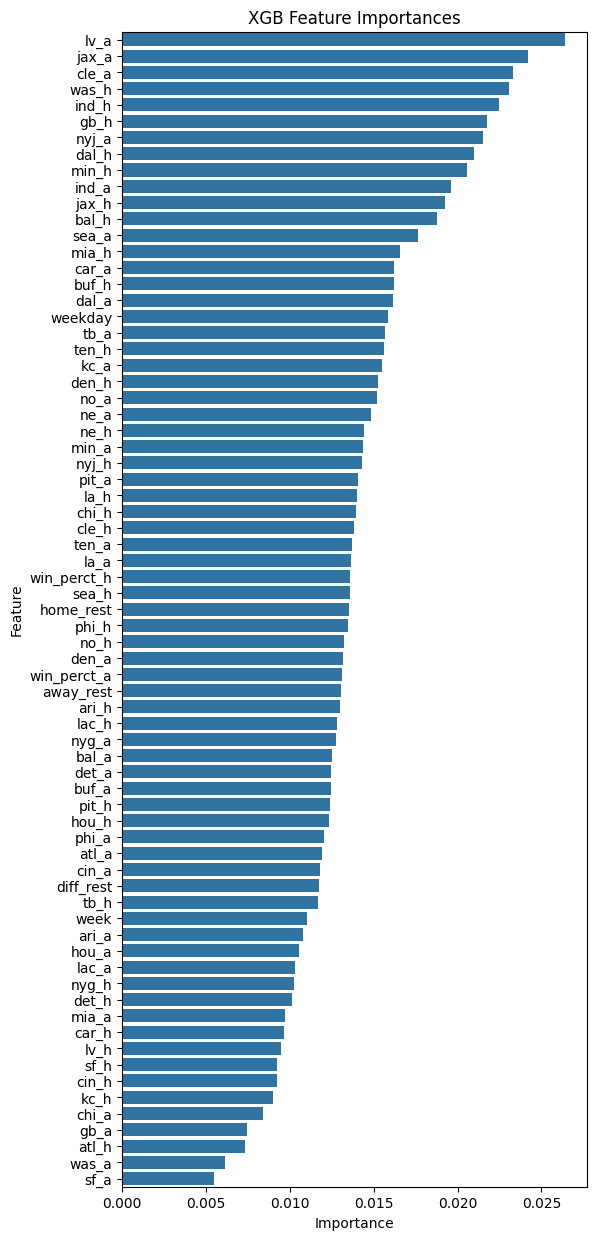

In [30]:
# Feature importances for the xgb model
importances = {}
for key, value in zip(xgb.feature_names_in_, xgb.feature_importances_):
    importances[key] = value

# Bar plot
plt.figure(figsize=(6, 15))
plt.title("XGB Feature Importances")
sns.barplot(
    data=pd.DataFrame(importances.items(), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False),
    x="Importance",
    y="Feature"
    )
plt.show()

## Prediction

Predict for the last two seasons, 2023 and 2024

In [31]:
# Save the predictions
nfl_predictions_df = nfl_predictions_df[nfl_predictions_df["season"] >= 2023].reset_index(drop=True)
nfl_predictions_df.head()

,season,week,weekday,home_team,away_team,home_rest,away_rest,diff_rest,tm_won_moneyline,win_perct_a,win_perct_h,home_won,moneyline_prob
0,2023,1,0,KC,DET,7,7,0,164.0,0.529412,0.850000,0,0.378788
1,2023,1,1,ATL,CAR,7,7,0,-192.0,0.411765,0.411765,1,0.657534
2,2023,1,1,BAL,HOU,7,7,0,-500.0,0.176471,0.555556,1,0.833333
3,2023,1,1,CLE,CIN,7,7,0,-108.0,0.736842,0.411765,1,0.519231
4,2023,1,1,IND,JAX,7,7,0,-205.0,0.526316,0.294118,0,0.672131


In [32]:
# Encode the teams
home = encode_teams(nfl_predictions_df, "home_team")
away = encode_teams(nfl_predictions_df, "away_team")
df_sub = nfl_predictions_df[["week", "weekday", "home_rest", "away_rest", "diff_rest", "win_perct_a", "win_perct_h"]]

In [33]:
# Store predictions
pred_df = pd.concat([home, away, df_sub], axis=1)
pred_vals = xgb.predict(pred_df)
model_predict_probs = xgb.predict_proba(pred_df).max(axis=1)

In [34]:
# Display predictions
nfl_predictions_df["prediction"] = pred_vals
display_df = nfl_predictions_df

In [35]:
# Store the team probability from last season
display_df["season_prob"] = np.where(display_df["home_won"] == 1, display_df["win_perct_h"], display_df["win_perct_a"])
display_df["model_prob"] = model_predict_probs
display_df["model_pred"] = np.where(display_df["prediction"] == 1, "Home", "Away")
display_df["won"] = np.where(display_df["home_won"] == 1, "Home", "Away")

In [36]:
# Prediction outcome is correct
display_df["outcome"] = np.where(
    (
        (display_df["home_won"] == 1) & (display_df["prediction"] == 1)
    ) | (
        (display_df["home_won"] == 0) & (display_df["prediction"] == 0)
    )
    , 
    "Correct",
    "Wrong"
    )

In [37]:
# Format the table
display_df.drop(columns=["weekday", "home_won", "home_rest", "away_rest", "diff_rest", "tm_won_moneyline", "win_perct_a", "win_perct_h", "prediction"], inplace=True)
display_df.head()

,season,week,home_team,away_team,moneyline_prob,season_prob,model_prob,model_pred,won,outcome
0,2023,1,KC,DET,0.378788,0.529412,0.743219,Home,Away,Wrong
1,2023,1,ATL,CAR,0.657534,0.411765,0.617241,Away,Home,Wrong
2,2023,1,BAL,HOU,0.833333,0.555556,0.920727,Home,Home,Correct
3,2023,1,CLE,CIN,0.519231,0.411765,0.789775,Away,Home,Wrong
4,2023,1,IND,JAX,0.672131,0.526316,0.572003,Home,Away,Wrong


In [38]:
# Was the model probability greater than or less than bookmaker
display_df["model_prob_diff"] = display_df["model_prob"] - display_df["moneyline_prob"]

In [39]:
# Change the name of columns on the dataframe
display_df.columns = display_df.columns.str.replace("_", " ").str.title()

In [ ]:
# Overall hit rate for the past two seasons
display_df["Outcome"].value_counts(normalize=True)

Outcome
Correct    0.608456
Wrong      0.391544
Name: proportion, dtype: float64

In [ ]:
# Results by season and model predictions
display_df.groupby(["Season", "Model Pred"])["Outcome"].value_counts(normalize=True)

Season  Model Pred  Outcome
2023    Away        Correct    0.543103
                    Wrong      0.456897
        Home        Correct    0.628205
                    Wrong      0.371795
2024    Away        Correct    0.628866
                    Wrong      0.371134
        Home        Correct    0.622857
                    Wrong      0.377143
Name: proportion, dtype: float64

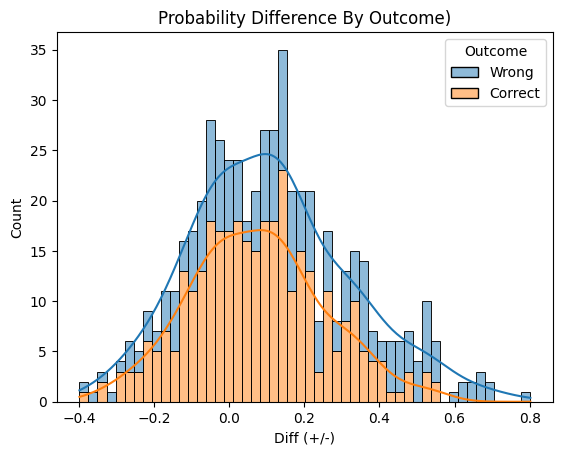

In [47]:
# Plot the diff value
sns.histplot(data=display_df, x="Model Prob Diff", hue="Outcome", multiple="stack", kde=True, bins=50)
plt.title("Probability Difference By Outcome)")
plt.xlabel("Diff (+/-)")
plt.show()

## Conclusion

- Model performed well predicting matchup winners for the 2024 compared to 2023 season
- Home wins are predicted more accurately
- Previous season win percentage improved model's prediction

In [48]:
joblib.dump(value=xgb, filename="matchup_model.joblib")

['matchup_model.joblib']